# option

In [1]:
import os
import argparse
home=os.path.expanduser("~")

##########################################################################################  
########################################################################################## 
class OptionG2C():
    def __init__(self, model_name='grid2code', domain='air', k=5, weightKNN='distance', 
                 batch_size=10, epochs=5, ae_type='code_length-4576'):
        self.model_name = model_name
        self.domain = domain
        self.k = k
        self.weightKNN = weightKNN
        self.batch_size = batch_size
        self.epochs = epochs
        self.ae_type = ae_type
        
class OptionS2C():
    def __init__(self, model_name='station2code', features='pm25', val_stations='Chaozhou', 
                domain='air', k=5, weightKNN='distance', batch_size=10, epochs=5, 
                ae_type='code_length-4576', dnn_type='embedding-0~bn-1'):
        self.model_name = model_name
        self.features = features
        self.val_stations = val_stations
        self.domain = domain
        self.k = k
        self.weightKNN = weightKNN
        self.batch_size = batch_size
        self.epochs = epochs
        self.ae_type = ae_type
        self.dnn_type = dnn_type
        
        
class OptionS2GSD():
    def __init__(self, model_name='station2gridSD', features='pm25', val_stations='Chaozhou', 
                 domain='air', k=5, weightKNN='distance', 
                 ae_type='code_length-4576', dnn_type='embedding-0~bn-1'):
        self.model_name = model_name
        self.features = features
        self.val_stations = val_stations
        self.domain = domain
        self.k = k
        self.weightKNN = weightKNN
        self.ae_type = ae_type
        self.dnn_type = dnn_type
            
class OptionS2GMD():
    def __init__(self, model_name='station2gridMD', features='pm25', val_stations='Chaozhou', 
                 batch_size=10, epochs=5, ae_type='code_length-4576', dnn_type='embedding-0~bn-1',
                 domains='air_3_distance~sat_3_distance', composite_type='composite-conv~filter-8x8'):
        self.model_name = model_name
        self.features = features
        self.val_stations = val_stations
        self.batch_size = batch_size
        self.epochs = epochs
        self.ae_type = ae_type
        self.dnn_type = dnn_type
        self.domains = domains
        self.composite_type = composite_type

# datasets

In [2]:
from glob import glob
from random import randint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod
import os
home = os.path.expanduser("~")
import sys
sys.path.append(os.path.join(home, 'station2grid'))

from tools import CommonObj
##########################################################################################
##########################################################################################
class DataBase(ABC):
    def __init__(self, opt):
        self.opt = opt
        self.setup()
        
    @abstractmethod
    def setup(self): pass
    
    def set_base_dir(self):
        source = 'domain_%s-k_%s-weightKNN_%s'%(self.opt.domain, self.opt.k, self.opt.weightKNN)
        self.base_dir = os.path.join(home, 'station2grid', 'datasets', 'npy', self.opt.domain, source)       
    
    def set_generator(self):
        self.x_train_paths, self.x_valid_paths, self.y_train_paths, self.y_valid_paths = \
        train_test_split(self.x_paths, self.y_paths ,test_size=0.2, random_state=42)     
        
        self.g_train = self.get_generator(self.x_train_paths, self.y_train_paths)
        self.g_valid = self.get_generator(self.x_valid_paths, self.y_valid_paths) 
    
    def get_generator(self, x_paths, y_paths):
        while True:
            batch_x = []
            batch_y = []
            for i in range(self.opt.batch_size):
                j=randint(0, len(x_paths)-1)
                
                x_path = x_paths[j] 
                x_arr = self.x_path2arr(x_path)
                batch_x.append(x_arr)
                
                y_path = y_paths[j] 
                y_arr = self.y_path2arr(y_path)
                batch_y.append(y_arr)
                
            batch_x = np.concatenate(batch_x, axis=0)
            batch_y = np.concatenate(batch_y, axis=0)
            yield batch_x, batch_y
            
    def grid_path2arr(self, path):
        arr = np.load(path)
        arr = arr[...,:1]
        arr = self.normalize(arr) 
        return arr
            
    def station_path2arr(self, path):
        arr = np.load(path)
        arr = arr[:, self.i_stations, :][..., self.i_features]
        #arr = self.normalize(arr) ###normalize
        return arr
    
    def code_path2arr(self, path):
        arr = np.load(path)
        arr = arr.reshape(1, -1)
        return arr
    
    def normalize(self, arr):
        norm_const = 100
        arr = arr / norm_const
        arr = arr.astype('float')
        return arr
    
    def denormalize(self, arr):
        norm_const = 100
        arr = norm_const * arr
        arr = arr.astype('float')
        return arr
    
    def setup_i_stations(self):        
        self.info = CommonObj().epa_station_info
        val_stations = self.opt.val_stations.split('_') 
        c = self.info.SiteEngName.isin(val_stations)
        self.train_info = self.info[~c]
        self.valid_info = self.info[c]
        
        self.i_stations = self.train_info.index.tolist()
        self.lats_lons = self.train_info[['row','col']].values 
        
    def setup_i_features(self):
        path = os.path.join(home,'station2grid','datasets','info','%s-features'%(self.opt.domain))
        domain_features = pd.read_csv(path).feature.tolist()
        features = self.opt.features.split('_')
        self.i_features = [domain_features.index(feature) for feature in features]
        #print(domain_features, features, self.i_features)

##########################################################################################
##########################################################################################        
class DataG2C(DataBase):
    def __init__(self, opt):
        super().__init__(opt)
        
    def setup(self):
        self.set_base_dir()
        self.set_paths()
        self.set_generator()
    
    def set_paths(self):
        self.x_paths = sorted(glob(os.path.join(self.base_dir, 'grid', '*')))[:] ###
        self.x_path2arr = self.grid_path2arr
        self.y_paths = sorted(glob(os.path.join(self.base_dir, 'grid', '*')))[:] ###
        self.y_path2arr = self.grid_path2arr
        
##########################################################################################
##########################################################################################
class DataS2C(DataBase):
    def __init__(self, opt):
        super().__init__(opt)
        
    def setup(self):
        self.setup_i_stations()
        self.setup_i_features()
        
        self.set_base_dir()
        self.set_paths()
        self.set_generator()
    
    def set_paths(self):
        self.x_paths = sorted(glob(os.path.join(self.base_dir, 'station', '*_norm.npy'))) ###
        self.x_path2arr = self.station_path2arr
        self.y_paths = sorted(glob(os.path.join(self.base_dir, 'code', self.opt.ae_type, '*'))) 
        self.y_path2arr = self.code_path2arr
               
##########################################################################################
##########################################################################################            
class DataS2G(DataBase):
    def __init__(self, opt):
        super().__init__(opt)
        
    def setup(self):
        self.setup_i_stations()
        self.setup_i_features()
    
    def setup_i_features(self):
        path = os.path.join(home,'station2grid','datasets','info','epa-features')
        domain_features = pd.read_csv(path).feature.tolist()
        
        domain2epa = {
            'pm25':'PM25',
            'pm10':'PM10',
            'temperature':'AMBTEMP',
            #'humidity':'RH'
        }
        features=self.opt.features
        for old in domain2epa: features = features.replace(old, domain2epa[old])
        features = features.split('_')
        
        self.i_features = [domain_features.index(feature) for feature in features]
    
    
    def setup_train(self):
        path = os.path.join(home,'station2grid','datasets','npy','epa','train_epa_addmou.npy') 
        self.x_raw = np.load(path) 
        
        path = os.path.join(home,'station2grid','datasets','npy','epa','train_epa_addmou_norm.npy') 
        self.x_raw_norm = np.load(path) ###
        
        self.x_all = self.x_raw_norm[:, self.i_stations, :][:, :, self.i_features] 
        self.y_all = self.x_raw_norm[:, self.i_stations, 0].reshape(-1, len(self.i_stations))
        
        self.x_train, self.x_valid, self.y_train, self.y_valid = \
        train_test_split(self.x_all, self.y_all, test_size=0.2, random_state=42)

    def setup_test(self): 
        path = os.path.join(home,'station2grid','datasets','npy','epa','test_epa_addmou.npy') 
        self.x_raw = np.load(path)
        self.x_raw_select = self.x_raw[:,self.i_stations,:][:,:,self.i_features] # x_raw_select
                
        path = os.path.join(home,'station2grid','datasets','npy','epa','test_epa_addmou_norm.npy') 
        self.x_norm = np.load(path)
        self.x_norm_select = self.x_norm[:,self.i_stations,:][:,:,self.i_features]   # x_norm_select    

        

# networks

In [3]:
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, UpSampling2D, \
BatchNormalization, Activation, Lambda, Concatenate, Reshape

from keras.models import Model, load_model
from keras import backend as K

import re
import pandas as pd
from glob import glob
import os

from tools import options, CommonObj

home = os.path.expanduser("~")
info = CommonObj().epa_station_info
n_all_stations = len(info)
#########################################################################################################
#########################################################################################################
class DNN():
    def __init__(self, opt):
        self.opt = opt
        self.setup()
    
    def setup(self):
        self.n_val_stations = len(self.opt.val_stations.split('_')) 
        self.n_features = len(self.opt.features.split('_')) 
        self.parse()
    
    def parse(self):
        key = 'code_length'
        self.code_length = int(re.search('(~|^)%s-(.+?)(~|$)'%(key), self.opt.ae_type).group(2))
        
    def define_dnn(self):
        num_station = n_all_stations - self.n_val_stations
        
        input_ = Input(shape=(num_station, self.n_features))
         
        if self.opt.dnn_type == 'a1': 
            x = Flatten()(input_)
            x = Dense(300, activation='relu')(x) 
            
        output_ = Dense(self.code_length, activation='linear')(x)
        
        model = Model(input_, output_)
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
        #model.summary() ###
        return model
    
    def get_dnn(self, weight):
        dnn = load_model(weight)
        return dnn

#########################################################################################################
#########################################################################################################
class Autoencoder():
    def __init__(self, opt): 
        self.opt = opt
        
    def define_autoencoder(self):
        input_shape = (348, 204, 1)
        input_img = Input(shape=input_shape)  

        x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(16, (3, 3), activation='relu')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        # autoencoder
        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        return autoencoder
        
    def get_encoder(self, weight): 
        autoencoder = load_model(weight)
        encoder = Model(autoencoder.input, autoencoder.layers[6].output)
        return encoder
    
    def get_decoder(self, weight): 
        autoencoder = load_model(weight)
        
        input_decoder = Input(shape=(44, 26, 4))
        x = autoencoder.layers[-7](input_decoder) 
        for i in range(6,(2)-1,-1):
            x = autoencoder.layers[-i](x) 
        output_decoder = autoencoder.layers[-1](x) 
        decoder = Model(input_decoder, output_decoder)
        return decoder
    

#########################################################################################################
#########################################################################################################
class CompositeNN():
    def __init__(self, opt):
        self.opt = opt
        self.setup()

    def setup(self):
        self.n_val_stations = len(self.opt.val_stations.split('_')) 
        self.n_features = len(self.opt.features.split('_')) 
        self.domains = [x.split('_') for x in self.opt.domains.split('~')]
        
    def define_cnn(self, input_):
        output_ = Conv2D(filters=1, kernel_size=(3,3), 
                         activation='relu', padding='same', name='conv')(input_)
        return output_
    
    def define_cnn_test(self, input_):
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(16, (3, 3), activation='relu')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
        return decoded 
    
    def define_s2gMD(self, lats_lons):
        input_shape = (n_all_stations - self.n_val_stations, self.n_features)
        input_ = Input(shape=input_shape)
        
        grid_norm_MD = [self.get_gridSD(domain, k, weightKNN, input_) for (domain, k, weightKNN) in self.domains]
        grid_norm_concat = Concatenate(name='concat_grid')(grid_norm_MD)
        
        x = BatchNormalization(name='bn')(grid_norm_concat) 
        
        grid_hat = self.define_cnn_test(x) ###
        
        output_ = Lambda(self.select_from_grid, arguments={'lats_lons': lats_lons})(grid_hat)
        
        model = Model(input_, output_)
        
        for layer in model.layers: 
            if layer.name in ['s2c-air','c2g-air', 's2c-sat','c2g-sat']: layer.trainable = False ###
        
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
        return model
    
    def get_s2gMD(self, weight):
        s2gMD_model = load_model(weight, custom_objects={'select_from_grid': self.select_from_grid})
        s2gMD_model_ = Model(s2gMD_model.input, s2gMD_model.layers[-2].output)
        return s2gMD_model_
    
    def select_from_grid(self, input_arr, lats_lons):
        epas=[input_arr[:, lat, lon, :] for lat,lon in lats_lons]
        output_arr=K.concatenate(epas)
        return output_arr
    
    def get_gridSD(self, domain, k, weightKNN, input_): 
        optionS2GSD = options.OptionS2GSD(
            domain=domain, k=k, weightKNN=weightKNN, 
            features=self.opt.features, val_stations=self.opt.val_stations, 
            ae_type=self.opt.ae_type, dnn_type=self.opt.dnn_type)
        
        modelS2GSD = ModelS2GSD(optionS2GSD)
        s2c_model = modelS2GSD.s2c_model 
        c2g_model = modelS2GSD.c2g_model
        group = '_'.join([domain, k, weightKNN])
        s2c_model.name = 's2c-%s'%(domain) ### 's2c-%s'%(group)
        c2g_model.name = 'c2g-%s'%(domain) ### 'c2g-%s'%(group)
        
        code = s2c_model(input_)
        code_reshape = Reshape(target_shape=(44, 26, 4))(code) 
        grid_norm = c2g_model(code_reshape)
        return grid_norm 
    

Using TensorFlow backend.


In [4]:
# name = 'conv1'
# check = [(x in name) for x in ['bn','conv']]
# any(check)

# model

## base

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

from abc import ABC, abstractmethod
from glob import glob
import pandas as pd
import os
home=os.path.expanduser("~")

import multiprocessing


class ModelBase(ABC):
    def __init__(self): pass
    
    @abstractmethod
    def setup(self): pass
    
    def train(self):
        print('training')
        g_train = self.data.g_train
        g_valid = self.data.g_valid
        callbacks = self.get_callbacks(min_delta=0, patience=20) ###
        
        self.history = self.model.fit_generator(
            generator = g_train,
            steps_per_epoch = (len(self.data.x_train_paths) // self.opt.batch_size),

            validation_data = g_valid,
            validation_steps = (len(self.data.x_valid_paths) // self.opt.batch_size),

            epochs = self.opt.epochs,
            verbose = 1, 
            callbacks = callbacks,

            use_multiprocessing = True,
            workers = multiprocessing.cpu_count(), # 32
            max_queue_size = 10,
        )
        
        self.save_history(self.history.history)
        print('finish!')
        
    def set_path(self):
        self.weight_path = os.path.join(
            home, 'station2grid', 'weights', self.group+'---'+'best_weight.hdf5')
        
        self.history_path = os.path.join(
            home, 'station2grid', 'weights', self.group+'---'+'history.csv')
    
    def set_group(self):
        dic = vars(self.opt)
        self.group = '--'.join(
            [key+'-'+str(dic[key]) for key in dic if key not in ['epochs', 'batch_size']] ###
        )
        
    def save_history(self, history):
        df_history = pd.DataFrame(history)
        df_history.to_csv(self.history_path, index=False)
    
    def get_callbacks(self, min_delta=0, patience=10):
        early_stopping = EarlyStopping(
            monitor='val_loss', mode='min', verbose=0, patience=patience, min_delta=min_delta) ### 

        checkpointer = ModelCheckpoint(
            filepath=self.weight_path, verbose=0, period=1, monitor='val_loss', 
            save_best_only=True, mode='min')

        callbacks = [early_stopping, checkpointer]
        return callbacks
        

## g2c

In [6]:

import os
import numpy as np

class ModelG2C(ModelBase):
    def __init__(self, opt):
        self.opt = opt
        self.setup()
        
    def setup(self):
        self.data = DataG2C(self.opt)
        self.autoencoder = Autoencoder(self.opt)###
        self.set_group()
        self.set_path()
        self.model = self.autoencoder.define_autoencoder()
        
    def test(self): 
        print('testing')        
        weight = self.weight_path
        encoder = self.autoencoder.get_encoder(weight)
        
        code_dir = os.path.join(self.data.base_dir, 'code', self.opt.ae_type)
        os.makedirs(code_dir, exist_ok=True)
        
        grid_paths = self.data.x_paths
        for grid_path in grid_paths[:]:
            grid = self.data.grid_path2arr(grid_path)
            code = encoder.predict(grid)
            code_name = grid_path.split('/')[-1].replace('grid', 'code')
            code_path = os.path.join(code_dir, code_name)
            np.save(code_path, code)
            print(code_path) ###
        print('finish!')
        

## s2c

In [7]:


class ModelS2C(ModelBase):
    def __init__(self, opt):
        self.opt = opt
        self.setup()
        
    def setup(self):
        self.data = DataS2C(self.opt)
        self.dnn = DNN(self.opt)###
        self.set_group()
        self.set_path()
        self.model = self.dnn.define_dnn()
        
        

## s2gsd

In [8]:

import os
home=os.path.expanduser("~")


class ModelS2GSD(ModelBase):
    def __init__(self, opt):
        self.opt = opt
        self.setup()    
        
    def setup(self):
        self.data = DataS2G(self.opt)
        self.set_group()
        
        optionS2C = options.OptionS2C(domain=self.opt.domain, 
                                      k=self.opt.k, 
                                      weightKNN=self.opt.weightKNN, 
                                      features=self.opt.features, 
                                      val_stations=self.opt.val_stations, 
                                      ae_type=self.opt.ae_type, 
                                      dnn_type=self.opt.dnn_type)   
        
        modelS2C = ModelS2C(optionS2C)###
        #print(modelS2C.weight_path)
        self.s2c_model = modelS2C.dnn.get_dnn(modelS2C.weight_path)
        
        optionG2C = options.OptionG2C(domain=self.opt.domain, 
                                      k=self.opt.k, 
                                      weightKNN=self.opt.weightKNN, 
                                      ae_type=self.opt.ae_type, )  
        modelG2C = ModelG2C(optionG2C)###
        #print(modelG2C.weight_path)
        self.c2g_model = modelG2C.autoencoder.get_decoder(modelG2C.weight_path)
        
    def test(self): 
        print('testing')
        self.data.setup_test()
        self.stations = self.data.x_norm_select
        
        codes = self.s2c_model.predict(self.stations)
        codes = codes.reshape(-1, 44, 26, 4)
        
        grids_norm = self.c2g_model.predict(codes)
        grids_denorm = self.data.denormalize(grids_norm)
        
        print('finish')
        return grids_denorm


## s2gmd

In [9]:

import pandas as pd
import os
from glob import glob
import numpy as np
home=os.path.expanduser("~")


class ModelS2GMD(ModelBase):
    def __init__(self, opt):
        self.opt = opt
        self.setup() 
       
    def setup(self): 
        self.data = DataS2G(self.opt)
        self.compositeNN = CompositeNN(self.opt)
        self.set_group()
        self.set_path()
    
    def train(self): 
        print('training...')
        
        self.data.setup_train() ###
        x_train, y_train = self.data.x_train, self.data.y_train
        x_valid, y_valid = self.data.x_valid, self.data.y_valid
        
        s2gMD_model = self.compositeNN.define_s2gMD(self.data.lats_lons)
        s2gMD_model.summary()
        
        callbacks = self.get_callbacks(min_delta=1/10000, patience=10) ###
        self.history = s2gMD_model.fit(
            x=x_train, 
            y=y_train,
            validation_data=(x_valid, y_valid),
            verbose=1, ###
            batch_size=self.opt.batch_size,
            epochs=self.opt.epochs,
            shuffle=False,
            callbacks=callbacks)
        
        self.save_history(self.history.history)
        print('finish!')
    
    def test(self): 
        print('testing...')
        self.data.setup_test()
        self.stations = self.data.x_norm_select
        
        s2gMD_model = self.compositeNN.get_s2gMD(self.weight_path)
        grids = s2gMD_model.predict(self.stations)
        grids = self.data.denormalize(grids) ###
        print('finish!')
        return grids
    


# plot

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Path, PathPatch
from tools.knn_model import KnnModel

def plotMap(ax,
            lats, lons, vals,
            title, title_size=18,
            latMin=21, latMax=26, lonMin=119, lonMax=123,
            bar_min=0, bar_max=70):    
    
    m = Basemap(projection='merc',
                llcrnrlat=latMin, urcrnrlat=latMax, llcrnrlon=lonMin, urcrnrlon=lonMax,
                lat_ts=20, resolution='i', ax=ax)
    
    parallels = [num for num in range(latMin,latMax)] # np.arange(21.,27.,1.0)
    meridians = [num for num in range(lonMin,lonMax)] # np.arange(118.,124.,1.0)
    m.drawparallels(parallels,labels=[0,0,0,0],linewidth=0.1) # 1,0,0,0
    m.drawmeridians(meridians,labels=[0,0,0,0],linewidth=0.1) # 0,0,0,1
    m.drawcoastlines()
    m.drawcountries()
    
    x, y = m(lons, lats)
    cmap = plt.cm.get_cmap('Reds')
    sc = ax.scatter(x, y, c=vals, vmin=bar_min, vmax=bar_max, cmap=cmap, s=50, edgecolors='none')
    cbar = plt.colorbar(sc, ax=ax)
    ax.set_title(title, fontdict={'fontsize': title_size})
    
    # mask area outside Taiwan
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])
    polys = [p.boundary for p in m.landpolygons]
    polys = [map_edges]+polys[:]
    codes = [ [Path.MOVETO]+[Path.LINETO for p in p[1:]] for p in polys]
    polys_lin = [v for p in polys for v in p]
    codes_lin = [xx for cs in codes for xx in cs]
    path = Path(polys_lin, codes_lin)
    patch = PathPatch(path,facecolor='white', lw=0)
    ax.add_patch(patch) 

# mse

In [11]:
from sklearn.metrics import mean_squared_error

def get_predict_result(y_true, y_hat, group, val_station_names=['Tainan','Taitung']):
        
    dts=pd.date_range(start='2019', end='2020', periods=None, freq='H', closed='left')

    a = pd.DataFrame(y_true)
    a.columns = val_station_names
    a['is_real'] = 'real'
    a['dt'] = dts

    b = pd.DataFrame(y_hat)
    b.columns = val_station_names
    b['is_real'] = 'predict'
    b['dt'] = dts

    c = pd.concat([a,b], axis=0)
    c['group'] = group
    
    c_melt = pd.melt(c, id_vars=['group', 'dt', 'is_real'], var_name='station', value_vars=val_station_names)

    c_pt = pd.pivot_table(
        c_melt, values='value', columns=['is_real'],
        index=['group', 'station', 'dt']).reset_index(drop=False)
    return c_pt

# testing

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"]='0' 

In [13]:
val_stations = 'Tainan'
features = 'pm25'

optionS2GSD = OptionS2GSD(features='pm25', val_stations=val_stations)
dataS2G = DataS2G(optionS2GSD)
model_knn = KnnModel(dataS2G)

In [14]:
dataS2G.setup_test()
dataS2G.x_raw_select.shape

(8760, 76, 1)

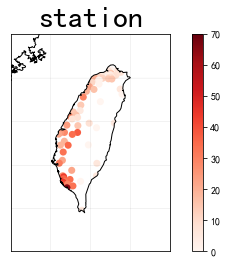

In [15]:
j = 300
nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(8, 4))
lats = dataS2G.train_info.lat.values
lons = dataS2G.train_info.lon.values
vals = dataS2G.x_raw_select[j].reshape(-1)
title = 'station'
plotMap(ax, lats, lons, vals, title, title_size=30)

In [16]:
# nrows, ncols = 2, 2
# fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))
# for row in range(nrows):
#     for col in range(ncols):
#         lats = dataS2G.train_info.lat.values
#         lons = dataS2G.train_info.lon.values
#         ax = axs[row, col]
#         vals = img_matrix[row][col]
#         plotMap(ax, lats, lons, vals, title, title_size=30)
        
# plt.show()

## s2c

In [17]:
# for domain in ['air','sat']:
#     optionS2C = OptionS2C(
#         domain= domain, k= 3, weightKNN= 'distance',
#         batch_size=300, 
#         epochs=300, ###
#         features=features,
#         val_stations=val_stations,
#         dnn_type='a1'
#     )
#     print('#'*80)
#     print(vars(optionS2C))
#     modelS2C = ModelS2C(optionS2C)
#     modelS2C.train()

#     K.clear_session() 

## s2gsd

In [18]:
optionS2GSD = OptionS2GSD(
    domain='air', k= 3, weightKNN= 'distance',
    features=features,
    val_stations=val_stations,
    dnn_type='a1'
)

In [19]:
modelS2GSD = ModelS2GSD(optionS2GSD)
grids_sd = modelS2GSD.test()

testing
finish


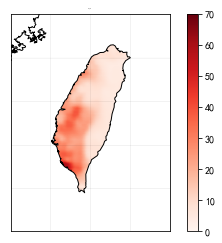

In [20]:
fig_num = 1
ax = plt.subplot(1, fig_num, 1)
lats = model_knn.coordinates[:,0]
lons = model_knn.coordinates[:,1]
vals = grids_sd[j,...].reshape(-1)
title = 'grids_sd'
plotMap(ax, lats, lons, vals, title, fig_num)

In [21]:
valid_info = modelS2GSD.data.valid_info
valid_idxs = valid_info.index.values
val_rows = valid_info.row.values
val_cols = valid_info.col.values

In [22]:
y_true = modelS2GSD.data.x_raw[:,valid_idxs,0]
y_hat = grids_sd[:,val_rows,val_cols,0]
group = modelS2GSD.group
val_station_names = val_stations.split('_')

predict_result = get_predict_result(y_true, y_hat, group, val_station_names=val_station_names)
predict_result.head()

is_real,group,station,dt,predict,real
0,model_name-station2gridSD--features-pm25--val_...,Tainan,2019-01-01 00:00:00,6.679486,17.0
1,model_name-station2gridSD--features-pm25--val_...,Tainan,2019-01-01 01:00:00,10.384362,20.0
2,model_name-station2gridSD--features-pm25--val_...,Tainan,2019-01-01 02:00:00,9.523227,14.0
3,model_name-station2gridSD--features-pm25--val_...,Tainan,2019-01-01 03:00:00,9.960392,15.0
4,model_name-station2gridSD--features-pm25--val_...,Tainan,2019-01-01 04:00:00,8.259117,10.0


In [23]:
mean_squared_error(predict_result.predict, predict_result.real)

31.260582939335354

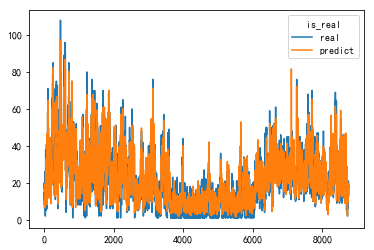

In [24]:
predict_result.plot(y=['real','predict',])

In [25]:
K.clear_session() 

## s2gmd

In [26]:
composite_type = 'c0'

optionS2GMD = OptionS2GMD(
    features=features,
    val_stations=val_stations,
    batch_size=50, epochs=10, ### 
    ae_type='code_length-4576', dnn_type='a1',
    domains='air_3_distance~sat_3_distance', 
    composite_type=composite_type, ###
) 

In [27]:
modelS2GMD = ModelS2GMD(optionS2GMD)

In [28]:
# modelS2GMD.train()

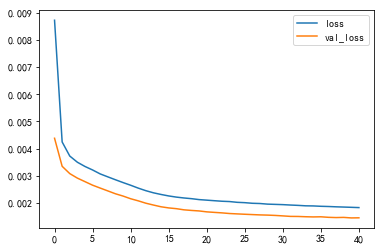

In [29]:
pd.read_csv(modelS2GMD.history_path).plot(y=['loss','val_loss'])

In [30]:
grids_md = modelS2GMD.test()

testing...


/media/disk3/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


finish!


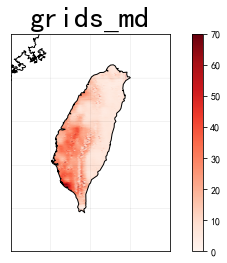

In [31]:
nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(8, 4))
lats = model_knn.coordinates[:,0]
lons = model_knn.coordinates[:,1]
vals = grids_md[j,...].reshape(-1)
title = 'grids_md'
plotMap(ax, lats, lons, vals, title, title_size=30)

In [32]:
valid_info = modelS2GMD.data.valid_info
valid_idxs = valid_info.index.values
val_rows = valid_info.row.values
val_cols = valid_info.col.values

In [33]:
y_true = modelS2GMD.data.x_raw[:,valid_idxs,0]
y_hat = grids_md[:,val_rows,val_cols,0]
group = modelS2GMD.group
val_station_names = val_stations.split('_')

predict_result = get_predict_result(y_true, y_hat, group, val_station_names=val_station_names)
predict_result.head()

is_real,group,station,dt,predict,real
0,model_name-station2gridMD--features-pm25--val_...,Tainan,2019-01-01 00:00:00,8.411392,17.0
1,model_name-station2gridMD--features-pm25--val_...,Tainan,2019-01-01 01:00:00,11.652475,20.0
2,model_name-station2gridMD--features-pm25--val_...,Tainan,2019-01-01 02:00:00,10.540440,14.0
3,model_name-station2gridMD--features-pm25--val_...,Tainan,2019-01-01 03:00:00,10.146630,15.0
4,model_name-station2gridMD--features-pm25--val_...,Tainan,2019-01-01 04:00:00,8.514750,10.0


In [34]:
mean_squared_error(predict_result.predict, predict_result.real)

37.877491804508864

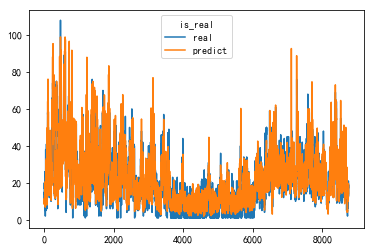

In [35]:
predict_result.plot(y=['real','predict',])

In [36]:
K.clear_session() 